# 2D Poisson problem with TV denoising using MYULA (Part 1)

This script provide code for figure 12 in section 5.2.4 of the paper. The goal is to infer log conductivity 𝜿 from measurements of potential u everywhere in the domain. The forward model is governed by the Possion equation with zero Dirichlet boundary conditions and source term $f(x_1, x_2)=1$.

$$ \nabla \cdot \left( e^{\kappa(x_1, x_2)} \nabla u(x_1, x_2) \right) = f(x_1, x_2) \;\; \text{ in } \;\;\Omega = (0,1)^2 $$

We use MYULA with TV denoising. For more details about the problem setup, please refer to the paper.

Additional resources for solving Poisson problem using CUQIpy-FEniCS:
- [CUQI book](https://cuqi-dtu.github.io/CUQI-Book/chapter04/Plugins/CUQIpy-FEniCS/poisson_2D_fenics.html)
- [Documentation](https://cuqi-dtu.github.io/CUQIpy-FEniCS/api/_autosummary/cuqipy_fenics.testproblem/cuqipy_fenics.testproblem.FEniCSPoisson2D.html#cuqipy_fenics.testproblem.FEniCSPoisson2D)
- [CUQIpy paper part II](https://arxiv.org/abs/2305.16951)



### Imports

In [1]:
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqi.experimental.mcmc import  ULA
from cuqi.samples import Samples
from cuqi.implicitprior import RestorationPrior, MoreauYoshidaPrior
from cuqipy_fenics.testproblem import FEniCSPoisson2D
from pde_myula_utils import (sample_in_batches,
                             plot_figure_12,
                             get_samples_at_line)
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
import os
import argparse
import sys

# Set logging level of dl
dl.set_log_level(dl.LogLevel.ERROR)

### Print CUQIpy and CUQIpy-FEniCS versions:

In [2]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)

1.3.0
0.8.0


### Parameters

Read parameter for TV strength from command line arguments, if any. If not provided, use default value (5.0 for TV_strength_factor).

An example command to run the notebook from command line using nbconvert is:
```
NB_ARGS=' --TV_strength_factor 6.0' jupyter nbconvert --execute --to notebook Poisson_2D_MYULA_Part1.ipynb --output Poisson_2D_MYULA_Part1_6.ipynb
```

In [3]:
parser = argparse.ArgumentParser(description='Run MYULA example for a given TV strength factor')
parser.add_argument('--TV_strength_factor', type=float, default=5.0, help='restoration strength factor for the TV prior')

# 'NB_ARGS' environment variable is set when running the notebook from command
# line using nbconvert as shown above.
try:
    os.environ['NB_ARGS']
except KeyError:
    os.environ['NB_ARGS'] = ''
args = parser.parse_args(os.environ['NB_ARGS'].split())

In [4]:
# Set random seed for reproducibility
np.random.seed(0)

Ns = 500000 # Number of samples
Nt= 20 # Thinning, take every Nt sample
Nb = 200 # Number of burn-in samples

noise_level = 0.01 # Level of noise in data

TV_weight_factor = args.TV_strength_factor # default 5.0
nx = 32 # (For nx by nx mesh)
sample_batches = True # Sample in batches to save memory

### Tag (used for file names, etc)

In [5]:
expr_tag = f"_nx_{nx}_rest_str_{TV_weight_factor}"
print(expr_tag)

_nx_32_rest_str_5.0


### Forward model

We use a CUQIpy-FEniCS test problem for the forward model.

In [6]:
A = FEniCSPoisson2D(dim=(nx,nx),
                    field_type=None,
                    mapping='exponential', # to infer log-conductivity
                    bc_types=['Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet']).model

We plot the mesh

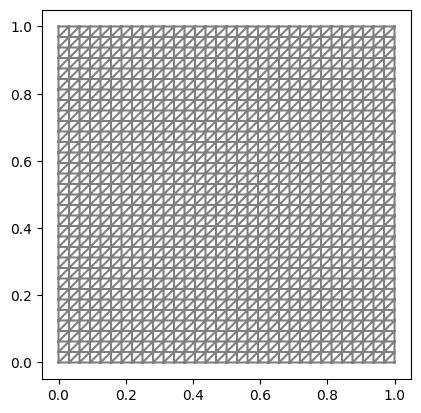

In [7]:
dl.plot(A.domain_geometry.mesh);

### Create true signal (true log-conductivity field)

We create a true log-conductivity field as a square inclusion of high conductivity at the center of the domain in a background of low conductivity and plot it.


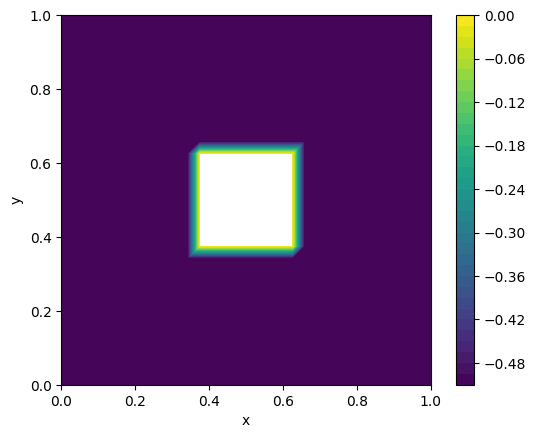

In [8]:
fun_kappa_true_expr = dl.Expression(
    '(x[0]>0.35 && x[0]< 0.65 && x[1]>0.35 && x[1]< 0.65) ? 0 : -0.5', degree=1)
kappa_true_fun = dl.interpolate(
    fun_kappa_true_expr, A.domain_geometry.function_space)
kappa_true = cuqi.array.CUQIarray(
    kappa_true_fun.vector().get_local(), geometry=A.domain_geometry)

im = kappa_true.plot()
plt.colorbar(im[0])

### Compute noise STD from noise level

We compute the noise standard deviation `s_noise` from the specified noise level and the norm of the noise-free data `y_true`.

In [9]:
y_true = A(kappa_true)
s_noise = 1.0/np.sqrt(A.domain_geometry.par_dim)* noise_level*np.linalg.norm(y_true)

### Create a MoreauYoshidaPrior

First we create a restore function that applies `denoise_tv_chambolle` to FEniCS functions (more precisely, to a grid representation of the function).

In [10]:
def restore_TV(x, restoration_strength=None):
    # x is 1D array representing the degrees of freedom of finite element
    # function (here it is values of the function on the nodes of the
    # uniform mesh)

    # Create FEniCS function from the array representation (the degrees of
    # freedom of the finite element function)
    H_prox = A.domain_geometry.function_space
    x_fun = dl.Function(H_prox)
    x_fun.vector()[:] = x

    # Convert the FEniCS function to a numpy array representing values of the
    # function on a 2D grid
    vertices_on_axis = int(np.sqrt(A.domain_geometry.mesh.num_vertices()))
    x_grid = x_fun.compute_vertex_values().reshape(
        (vertices_on_axis, vertices_on_axis))

    # Apply denoising on the grid representation of the function
    denoised_image = denoise_tv_chambolle(
        x_grid,
        weight=TV_weight_factor*restoration_strength,
        max_num_iter=100)

    # Convert (reorder) the denoised image back to FEniCS function degrees
    # of freedom
    d2v = dl.dof_to_vertex_map(A.domain_geometry.function_space)
    reordered_denoised_image = denoised_image.flatten()[d2v]

    return  reordered_denoised_image, None

We then create the restoration object

In [11]:
restorator = RestorationPrior(
        restore_TV,
        geometry=A.domain_geometry
    )

And the `MoreauYoshidaPrior`

In [12]:
restoration_strength = 0.5 * s_noise**2
x = MoreauYoshidaPrior(restorator, smoothing_strength=restoration_strength)

### Create the data distribution and the data

We create the data distribution

In [13]:
y = Gaussian(A(x), s_noise**2, geometry=A.range_geometry)

And synthetic noisy data

In [14]:
y_obs = y(x=kappa_true).sample()

And plot both

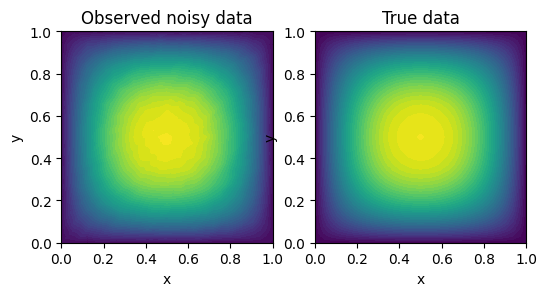

In [15]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
plt.sca(ax[0])
y_obs.plot(subplots=False, title='Observed noisy data')
plt.sca(ax[1])
y_true.plot(subplots=False, title='True data')

### Create the Bayesian problem

Create the Bayesian problem and obtain the posterior distribution

In [16]:
BP = BayesianProblem(y, x).set_data(y=y_obs)
posterior = BP.posterior()

### Sample the posterior

Sample the posterior using ULA (effectively this is MYULA since we are using a Moreau-Yoshida prior).

In [17]:
initial_point = np.ones(A.domain_geometry.par_dim)*-0.25
   
sampler = ULA(posterior, scale=1e-4, initial_point=initial_point)

If the flag `sample_batches` is set to True, we sample in batches. This is helpful in the case of large number of samples to avoid memory issues.

In [18]:
sampler.warmup(Nb)
sampler._samples = [] # clear samples after warmup

if sample_batches:
    posterior_samples = sample_in_batches(sampler, Ns, Nt, A)
else:
    sampler.sample(Ns)
    posterior_samples = sampler.get_samples()
    posterior_samples = posterior_samples.burnthin(Nb=0, Nt=Nt)

Warmup: 100%|██████████| 200/200 [00:07<00:00, 27.23it/s, acc rate: 100.00%]


batch number 0 of 10


Sample: 100%|██████████| 50000/50000 [31:25<00:00, 26.52it/s, acc rate: 100.00%]


batch number 1 of 10


Sample: 100%|██████████| 50000/50000 [31:10<00:00, 26.73it/s, acc rate: 100.00%]


batch number 2 of 10


Sample: 100%|██████████| 50000/50000 [31:05<00:00, 26.81it/s, acc rate: 100.00%]


batch number 3 of 10


Sample: 100%|██████████| 50000/50000 [31:04<00:00, 26.82it/s, acc rate: 100.00%]


batch number 4 of 10


Sample: 100%|██████████| 50000/50000 [31:08<00:00, 26.76it/s, acc rate: 100.00%]


batch number 5 of 10


Sample: 100%|██████████| 50000/50000 [31:14<00:00, 26.67it/s, acc rate: 100.00%]


batch number 6 of 10


Sample: 100%|██████████| 50000/50000 [31:13<00:00, 26.69it/s, acc rate: 100.00%]


batch number 7 of 10


Sample: 100%|██████████| 50000/50000 [31:06<00:00, 26.79it/s, acc rate: 100.00%]


batch number 8 of 10


Sample: 100%|██████████| 50000/50000 [30:55<00:00, 26.95it/s, acc rate: 100.00%]


batch number 9 of 10


Sample: 100%|██████████| 50000/50000 [31:00<00:00, 26.88it/s, acc rate: 100.00%]


Then we save the samples and the noisy data to a file

In [19]:
# Save the samples and the noisy data to a file
# Directory
results_dir = './results/'

# Check if the directory exists
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Results file
results_file = results_dir + "posterior_samples_2D" + expr_tag + ".npz"
np.savez(results_file, posterior_samples=posterior_samples.samples, noisy_data=y_obs.funvals.vector().get_local())

### Plot results

Extract samples at line x_2 = 0.5 to be used later for plotting

In [20]:
xx = np.linspace(0, 1, 100)
yy = np.ones_like(xx)*0.5
line_samples = get_samples_at_line(posterior_samples, xx, yy)

Extract `kappa_true` value at the same line

In [21]:
exact_line = []
for x_i, y_i in zip(xx, yy):
        exact_line.append(kappa_true_fun(x_i, y_i))
exact_line = np.array(exact_line)


Print the effective sample size (ESS) 

In [22]:
ess_list = posterior_samples.compute_ess()
print('ESS min: '+str(int(np.min(ess_list)))+', max:'+str(int(np.max(ess_list)))+', mean:'+str(int(np.mean(ess_list))))

ESS min: 140, max:1222, mean:605


Plot figure 12:

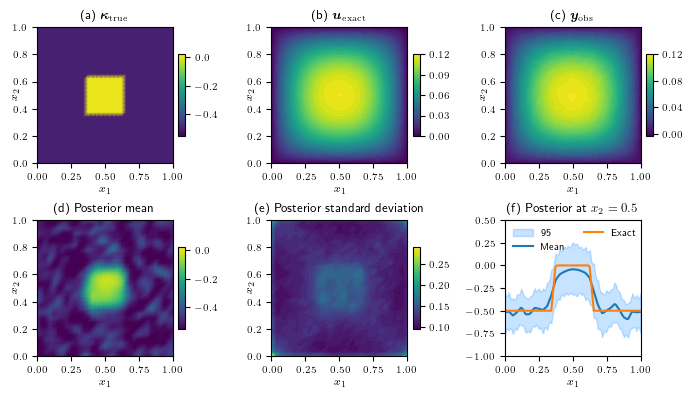

In [23]:
# Plot figure 12
plot_figure_12(
    kappa_true, y_true, y_obs, posterior_samples, line_samples, exact_line, xx)

# Save the figure
# Figure directory
fig_dir = './figs/'

# Check if the directory exists
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Figure version
version = 'v8'

# Figure file
fig_file = fig_dir + 'paper_figure1_'+expr_tag+'_'+version+'.pdf'
plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=600)